<a href="https://colab.research.google.com/github/YoanaKC/The-eagles/blob/main/midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds

dataset_name = "oxford_iiit_pet"
dataset, info = tfds.load(dataset_name, with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.U9NKHZ_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.U9NKHZ_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

In [ ]:
import tensorflow as tf

def augment(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    return image, label


In [ ]:
import tensorflow_hub as hub

detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Oxford-IIIT Pet Dataset
dataset_name = "oxford_iiit_pet"
dataset, info = tfds.load(dataset_name, with_info=True, as_supervised=True)
train_data, test_data = dataset['train'], dataset['test']

# Function to resize and normalize images
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0  # Normalize pixel values
    return image, label

train_data = train_data.map(preprocess).batch(32).shuffle(1000)
test_data = test_data.map(preprocess).batch(32)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Load Pretrained SSD MobileNet V2 Model
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

# Define a custom object detection model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(info.features['label'].names), activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(train_data, validation_data=test_data, epochs=10)

# Evaluate Model
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.2f}")

# Save Model
model.save("oxford_pet_detector.h5")

# Model Quantization for Optimization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save quantized model
with open("oxford_pet_detector_quantized.tflite", "wb") as f:
    f.write(tflite_model)

print("Model training and optimization completed!")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.L40Y7F_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.L40Y7F_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 219ms/step - accuracy: 0.5914 - loss: 1.5302 - val_accuracy: 0.8343 - val_loss: 0.5206
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.9091 - loss: 0.2868 - val_accuracy: 0.8258 - val_loss: 0.5637
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 129ms/step - accuracy: 0.9480 - loss: 0.1624 - val_accuracy: 0.8517 - val_loss: 0.4949
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 129ms/step - accuracy: 0.9665 - loss: 0.1027 - val_accuracy: 0.8517 - val_loss: 0.4992
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.9821 - loss: 0.0595 - val_accuracy: 0.8520 - val_loss: 0.5388
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.9889 - loss: 0.0380 - val_accuracy: 0.8629 - val_loss: 0.5137
Epoch 7/10
115/115 ━━━━━━━

Test Accuracy: 0.87
Saved artifact at '/tmp/tmpmmy_gcyy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 37), dtype=tf.float32, name=None)
Captures:
  138158785781328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138156586186512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138156586186128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138156586186704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138156586173264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138156586186896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138156586175184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138156586186320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138156586187856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138156586187664: TensorSpec(shape=(), dtype=tf.resource, na

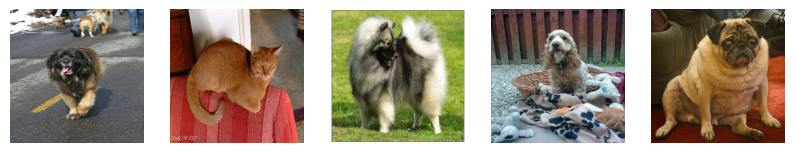

In [ ]:
# Visualize Sample Images (Before Preprocessing)
def show_sample_images(dataset, num_images=5):
    plt.figure(figsize=(10, 5))
    for i, (image_batch, label_batch) in enumerate(dataset.take(num_images)):
        # Iterate through images in the batch
        for j, image in enumerate(image_batch):
            if (i * image_batch.shape[0] + j) < num_images:
                plt.subplot(1, num_images, i * image_batch.shape[0] + j + 1)
                plt.imshow(image)
                plt.axis('off')
            else:
                break  # Stop if num_images is reached
    plt.show()

show_sample_images(train_data)

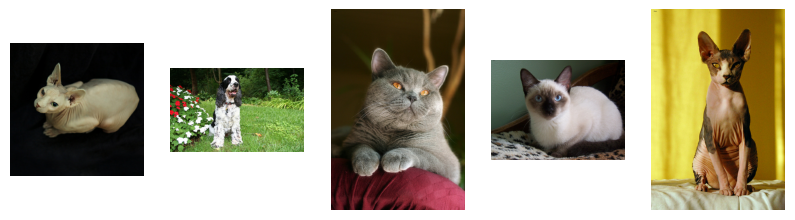

Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 276ms/step - accuracy: 0.4746 - loss: 2.0962 - val_accuracy: 0.8419 - val_loss: 0.5623
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.9155 - loss: 0.3533 - val_accuracy: 0.8618 - val_loss: 0.4581
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.9479 - loss: 0.2233 - val_accuracy: 0.8689 - val_loss: 0.4258
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.9717 - loss: 0.1577 - val_accuracy: 0.8705 - val_loss: 0.4109
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.9849 - loss: 0.1172 - val_accuracy: 0.8719 - val_loss: 0.4046


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the Oxford-IIIT Pet Dataset
dataset_name = "oxford_iiit_pet"
dataset, info = tfds.load(dataset_name, with_info=True, as_supervised=True)

# Extract training and testing datasets
train_data, test_data = dataset["train"], dataset["test"]

# Function to display images
def show_images(dataset, num_images=5):
    plt.figure(figsize=(10, 5))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

# Display some training images
show_images(train_data)

# Data Preprocessing
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0  # Normalize
    return image, label

train_data = train_data.map(preprocess).batch(32)
test_data = test_data.map(preprocess).batch(32)

# Load a pre-trained SSD MobileNet V2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

# Build an object detection model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(37, activation='softmax')  # 37 pet classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_data, epochs=5, validation_data=test_data)

# Save the model
model.save("oxford_pet_detector.h5")